<a href="https://colab.research.google.com/github/ahmedmabrook/DCGAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building GAN



Importing Libraries

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt


Importing Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Data Loading & Preprocessing
# We use batch_size 64 and normalize to [-1, 1] because Generator uses Tanh
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#loading mnist dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
#its function is to divide the 'train_dataset' into several batches of size 64 instead of sending the whole dataset which may crash the RAM
#shuffle=true is essential to prevent the GAN from remembering the sequence, to better generalize the generation and discrimination
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.55MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.5MB/s]


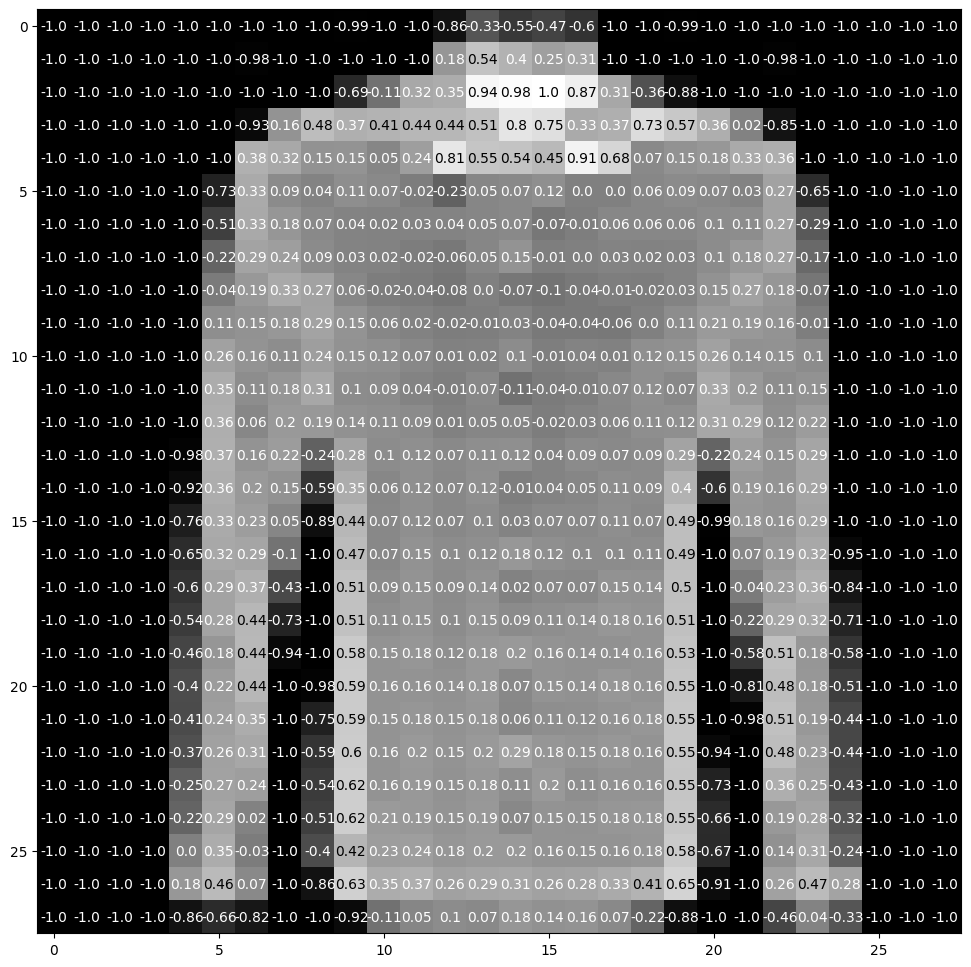

In [3]:

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5

    for x in range(width):
        # FIX 1: Indent this loop so it runs inside the x loop
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

# FIX 2: Handle the PyTorch Dataset structure
# train_dataset[i] returns a tuple: (tensor_image, label)
# We take [0] to get the image
image_tensor, label = train_dataset[5015]

# FIX 3: Squeeze the tensor
# The tensor shape is [1, 28, 28]. We need [28, 28] for the loop to work.
img_numpy = image_tensor.squeeze().numpy()

visualize_input(img_numpy, ax)
plt.show()

Building Generator

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    #fully connected layer, expects 100 features as input
    # and it output a 1D vector of size 7*7*128 = 6272
    # also it has a RelU activation
    self.dense = nn.Sequential(
        nn.Linear(100, 7 * 7 * 128),
        nn.ReLU()
    )

    self.conv_layers = nn.Sequential(
        #Block #1 (7x7)
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128, momentum=0.8),
        nn.ReLU(),

        #Block #2 (14x14)
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64, momentum=0.8),
        nn.ReLU(),

        #Block #3 (28x28 -> 1)
        nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        #using tanh instead of ReLu to avoid generating pixels > +255
        #tanh is normalized between -1 and 1
        nn.Tanh(),
    )

  def forward(self,z):
      x = self.dense(z)
      #reshaping the 1D vector into a 128x7x7
      x = x.view(x.shape[0], 128, 7, 7)
      x = self.conv_layers(x)
      return x



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
gen = Generator().to(device)
print(gen)

Generator(
  (dense): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (conv_layers): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)


Building Discriminator

In [7]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=2),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.25),
      #(14x14 -> 7x7)
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
      #add nothing to left, column of zeros to right
      #add nothing to top, column of zeros to bottom
      #(7x7 -> 8x8)
      nn.ZeroPad2d((0,1,0,1)),
      nn.BatchNorm2d(64, momentum=0.8),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.25),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
      nn.BatchNorm2d(128, momentum=0.8),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.25),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256, momentum=0.8),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.25),

      nn.Flatten(),
      nn.Linear(256 * 4 * 4, 1),
      nn.Sigmoid()
    )


  def forward(self, img):
      x = self.conv(img)
      return x



In [8]:
disc = Discriminator().to(device)
print(disc)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ZeroPad2d((0, 1, 0, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.25, inplace=False)
    (16): Flatten(start_dim=1, end_di

In [9]:
loss_func = nn.BCELoss()
optimizer_G = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    # 1. Set to evaluation mode (turns off Batch Norm training behavior for clearer images)
    generator.eval()

    # 2. Generate Noise (Latent Vector)
    # We must use torch.randn, not np.random.normal, and send it to the GPU
    noise = torch.randn(examples, 100, device=device)

    # 3. Generate Images
    with torch.no_grad(): # We don't need gradients for plotting
        generated_images = generator(noise).cpu() # Move back to CPU for matplotlib

    # 4. Reshape and Plot
    # PyTorch is (N, Channels, H, W). We need (N, H, W) for grayscale plotting
    generated_images = generated_images.view(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        # 'gray' is usually better than 'gray_r' for FashionMNIST (black background),
        # but you can keep 'gray_r' if you prefer inverted colors.
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show() # Show it in the notebook too

    # Switch back to training mode
    generator.train()

Epoch    | D Loss     | G Loss     | D(x) Real  | D(G(z)) Fake
-----------------------------------------------------------------

--- NETWORK INSPECTION (First Batch) ---
1. gen Input (Noise): 64 vectors of size 100
2. gen Output (Fake Imgs): 64 images of size torch.Size([1, 28, 28])
3. disc Input: Images of size torch.Size([1, 28, 28])
------------------------------------------

0        | 0.4233     | 1.6014     | 0.6944     | 0.2989


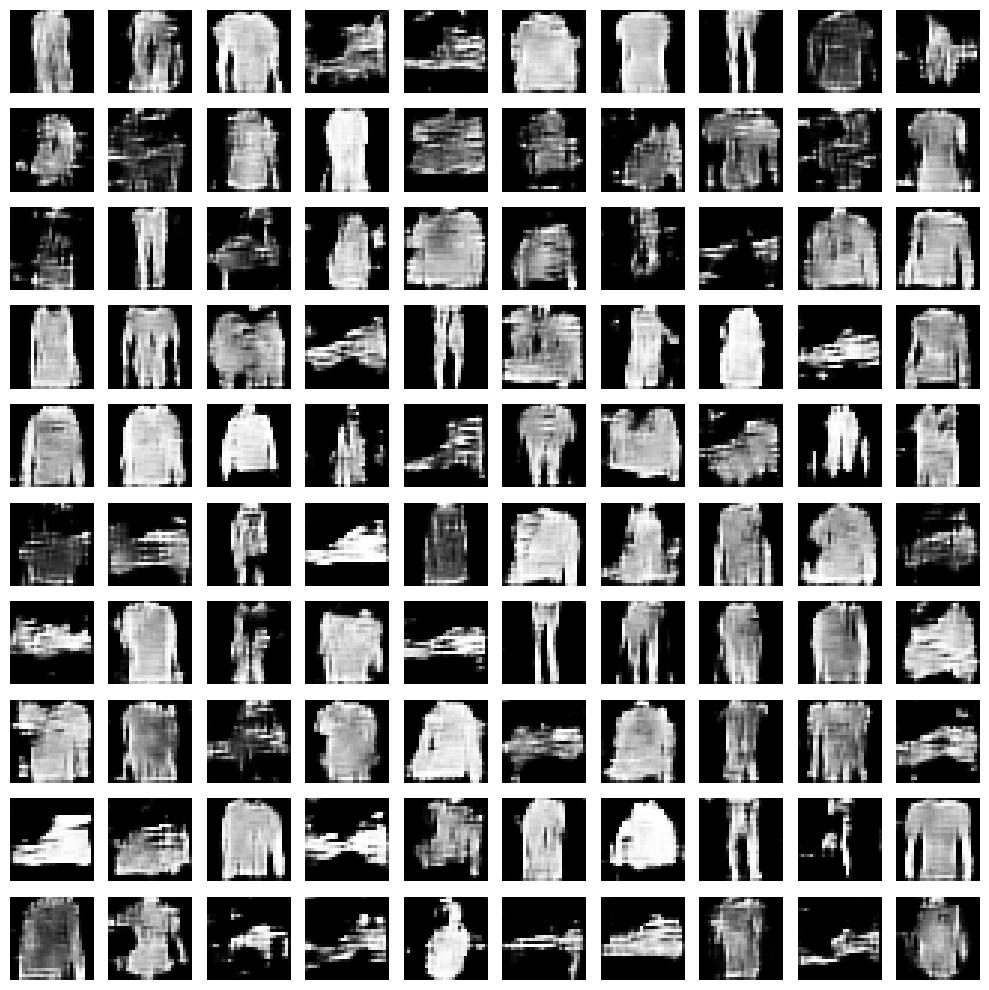

1        | 0.4308     | 1.5880     | 0.6942     | 0.3026
2        | 0.4292     | 1.6419     | 0.6969     | 0.3007


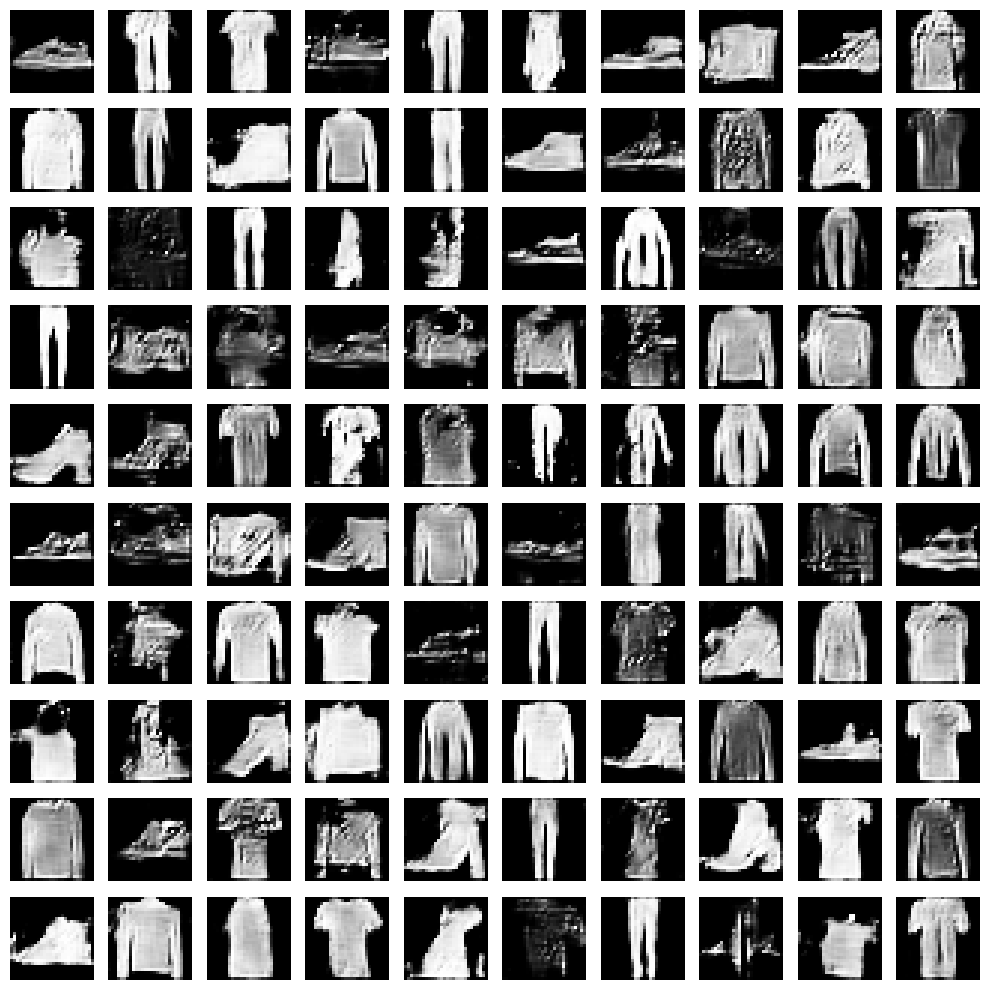

3        | 0.4172     | 1.6902     | 0.7075     | 0.2907
4        | 0.4131     | 1.7524     | 0.7144     | 0.2842


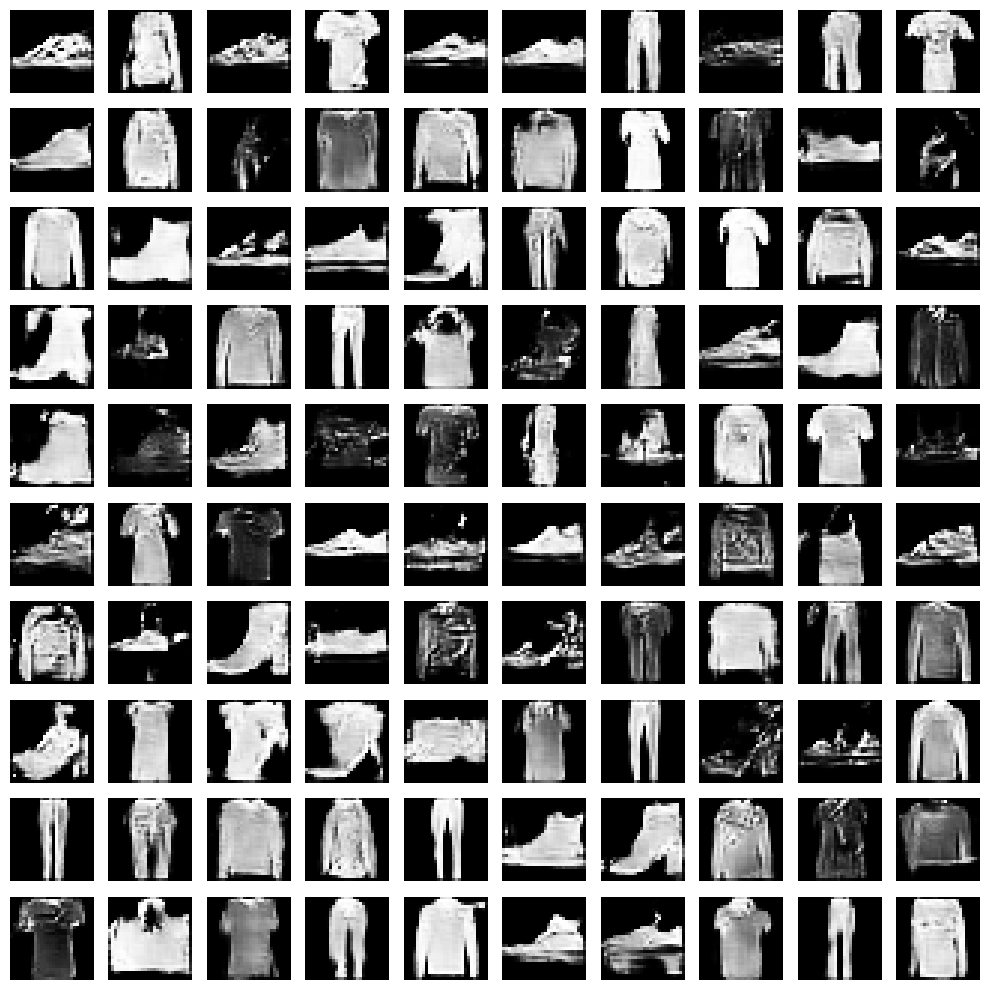

5        | 0.4096     | 1.8086     | 0.7189     | 0.2794
6        | 0.4098     | 1.8516     | 0.7213     | 0.2775


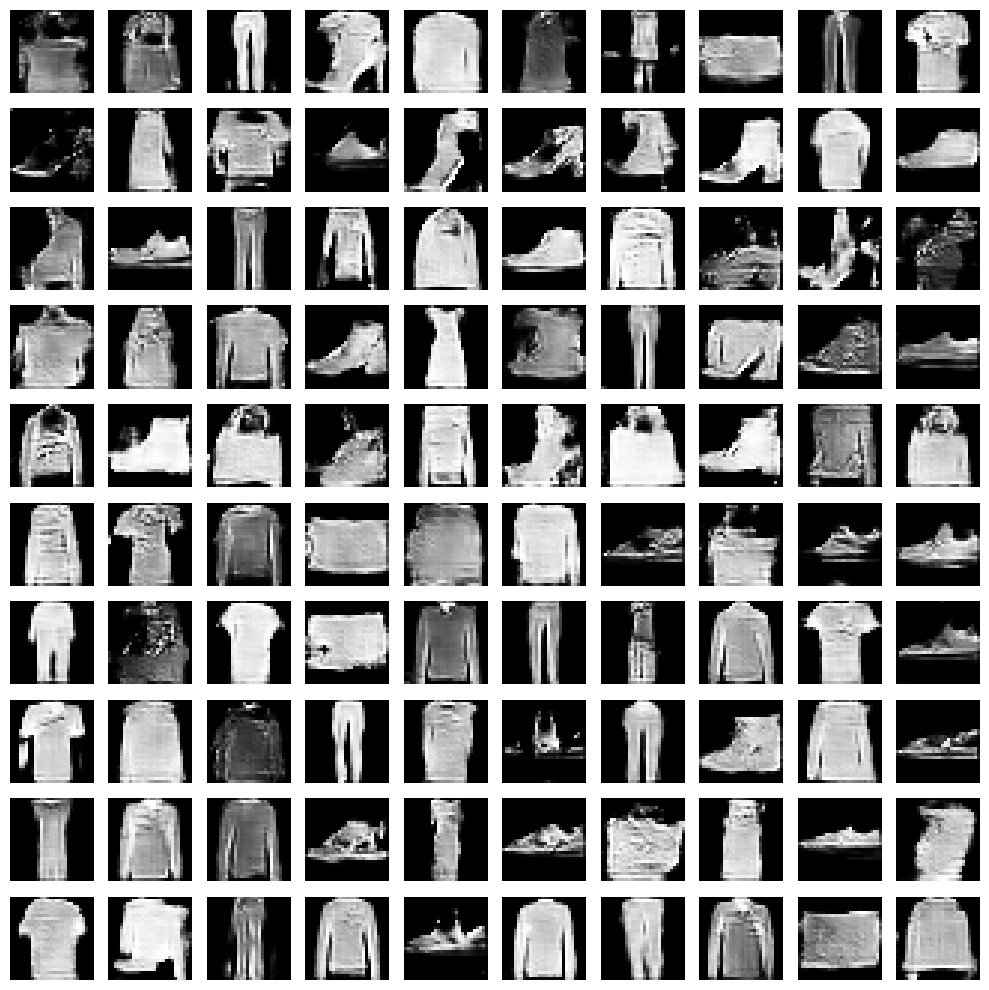

7        | 0.4089     | 1.8878     | 0.7237     | 0.2752
8        | 0.4016     | 1.9297     | 0.7291     | 0.2696


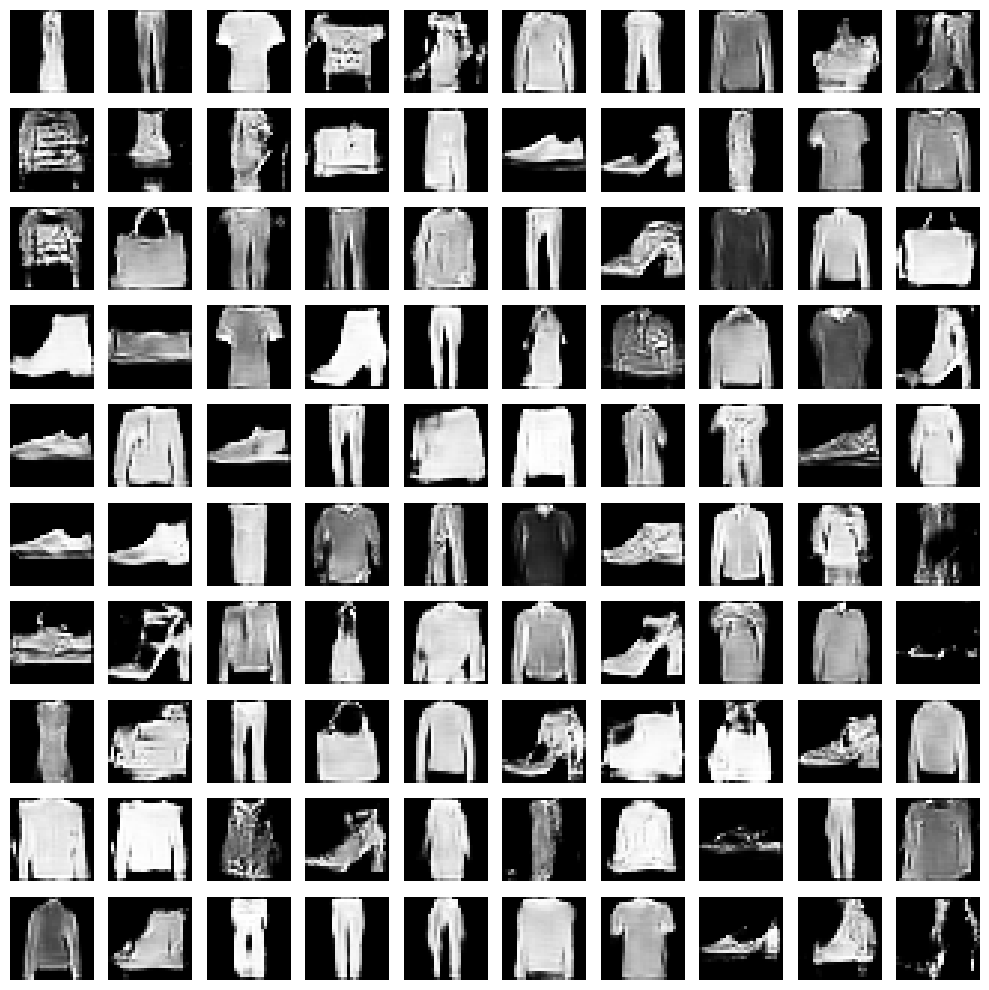

9        | 0.3990     | 1.9331     | 0.7319     | 0.2673
10       | 0.4072     | 1.9781     | 0.7310     | 0.2683


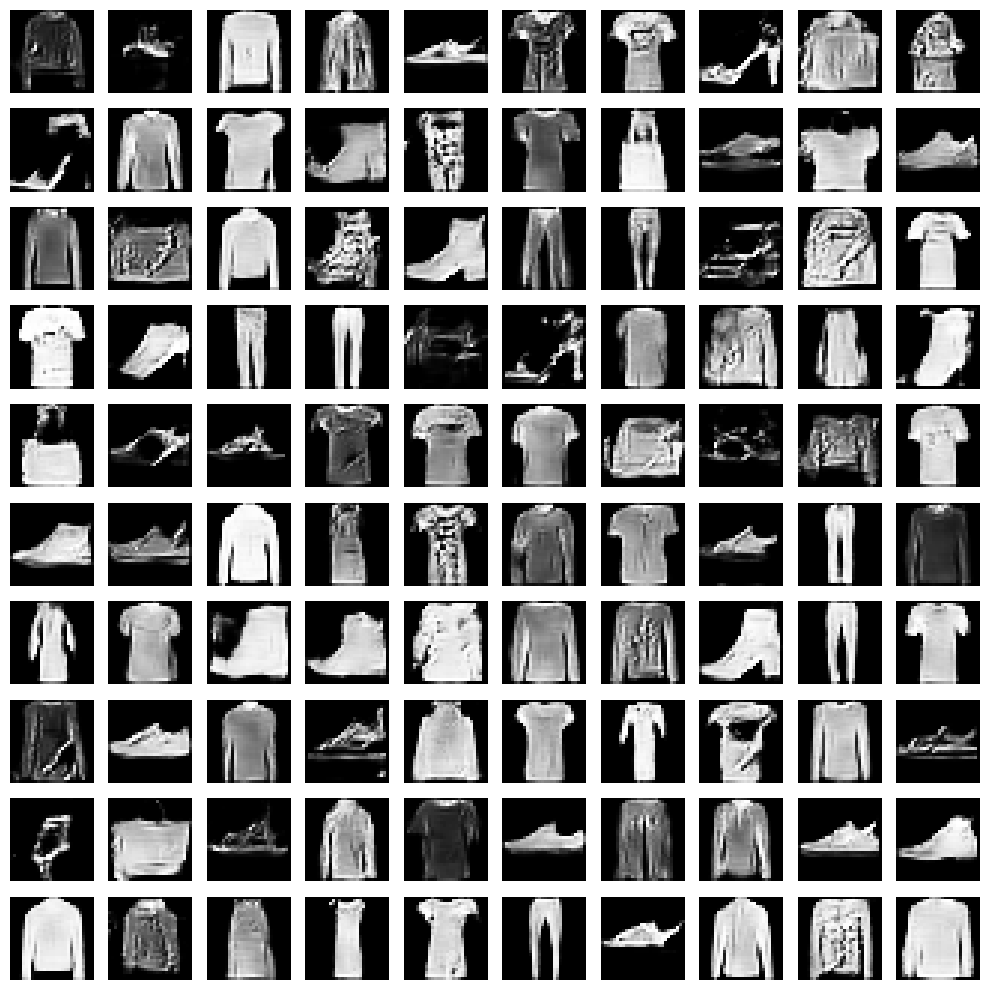

11       | 0.4099     | 2.0006     | 0.7290     | 0.2695
12       | 0.4000     | 1.9904     | 0.7349     | 0.2642


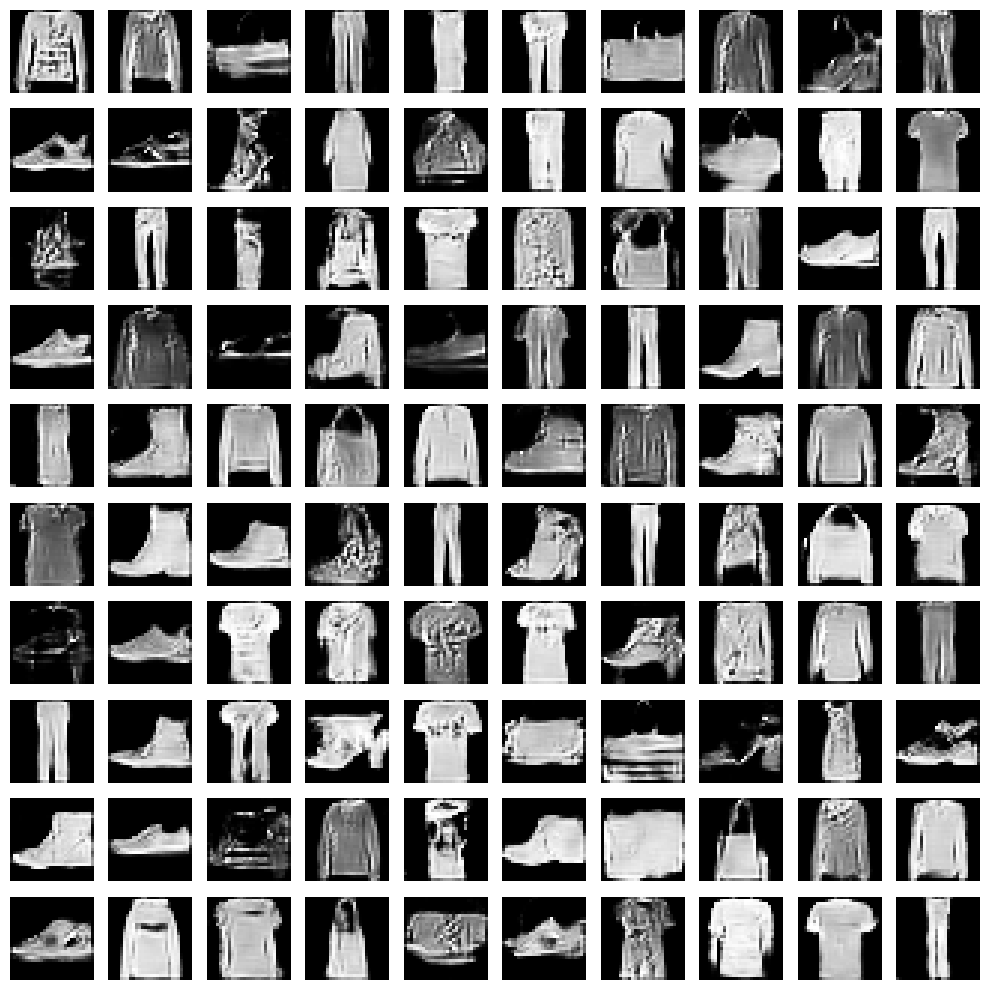

13       | 0.4081     | 2.0258     | 0.7319     | 0.2670
14       | 0.3950     | 2.0440     | 0.7382     | 0.2608


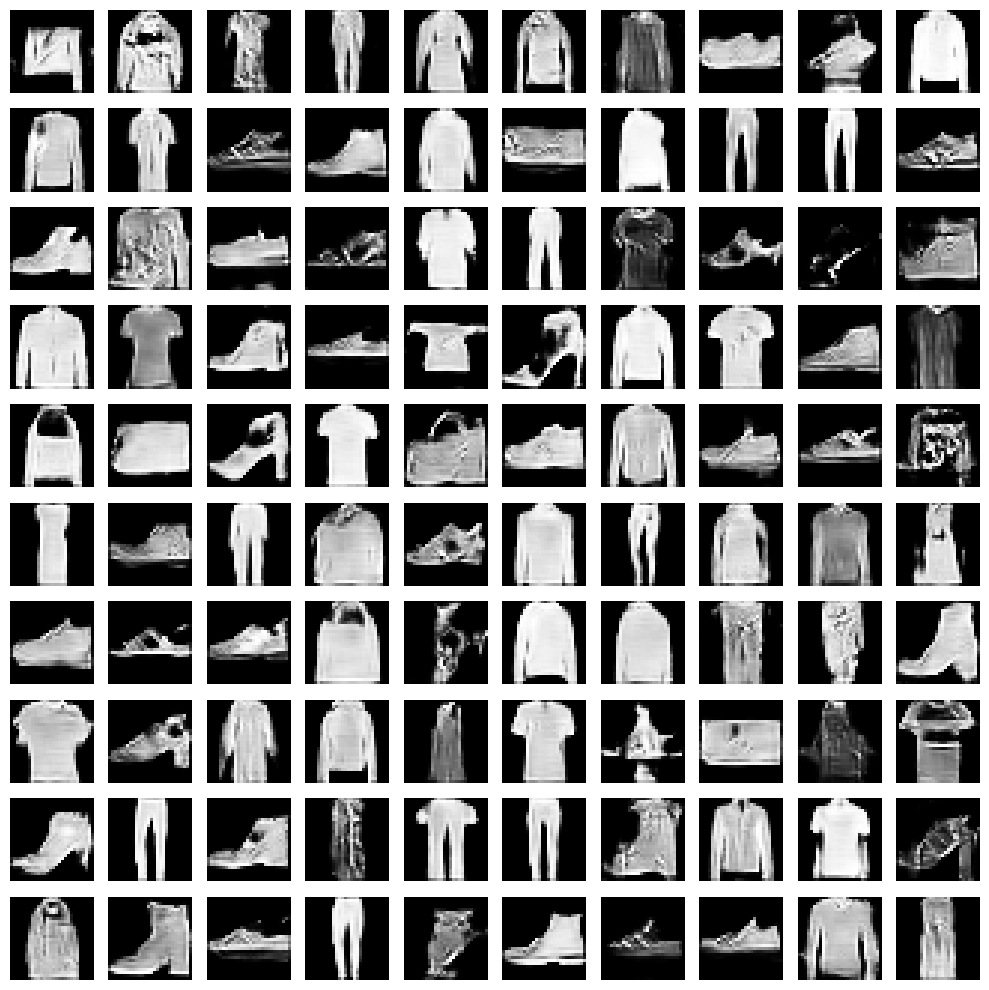

15       | 0.4010     | 2.0340     | 0.7357     | 0.2635
16       | 0.3917     | 2.1024     | 0.7423     | 0.2567


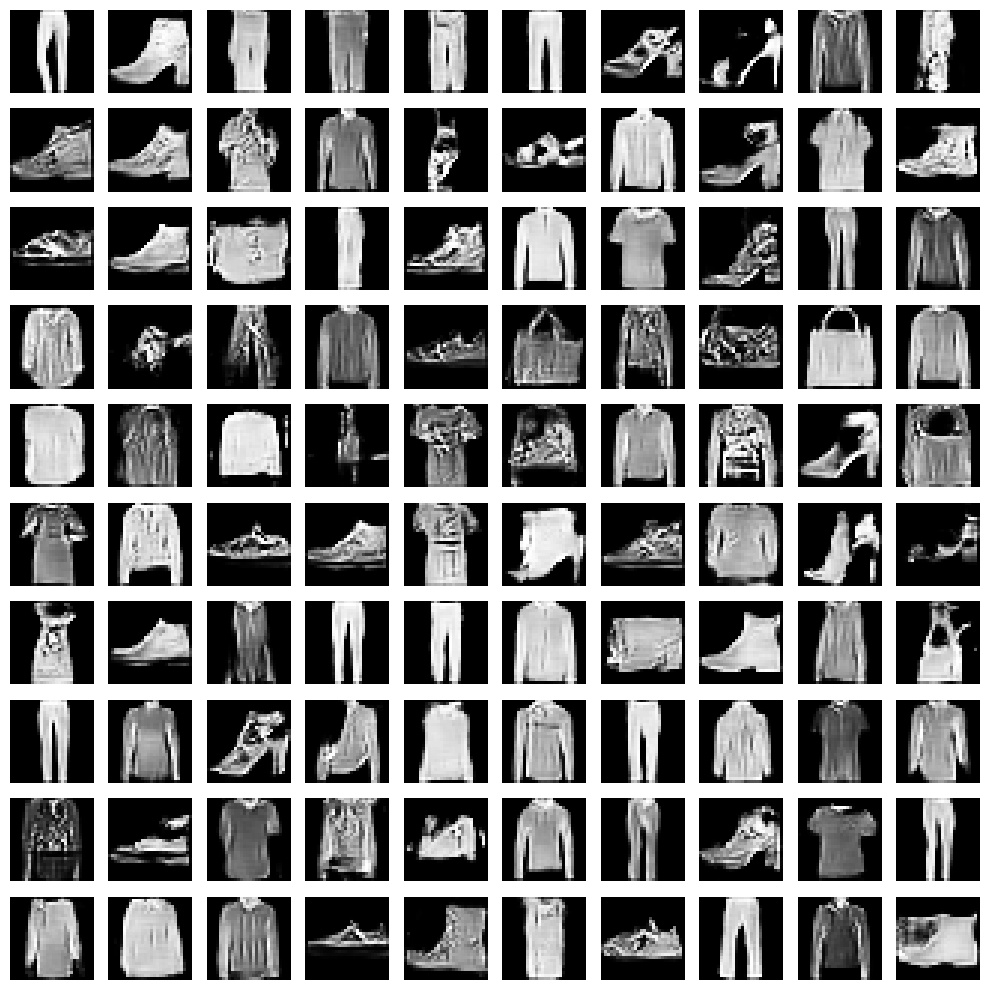

17       | 0.3944     | 2.0855     | 0.7418     | 0.2566
18       | 0.4064     | 2.0985     | 0.7369     | 0.2627


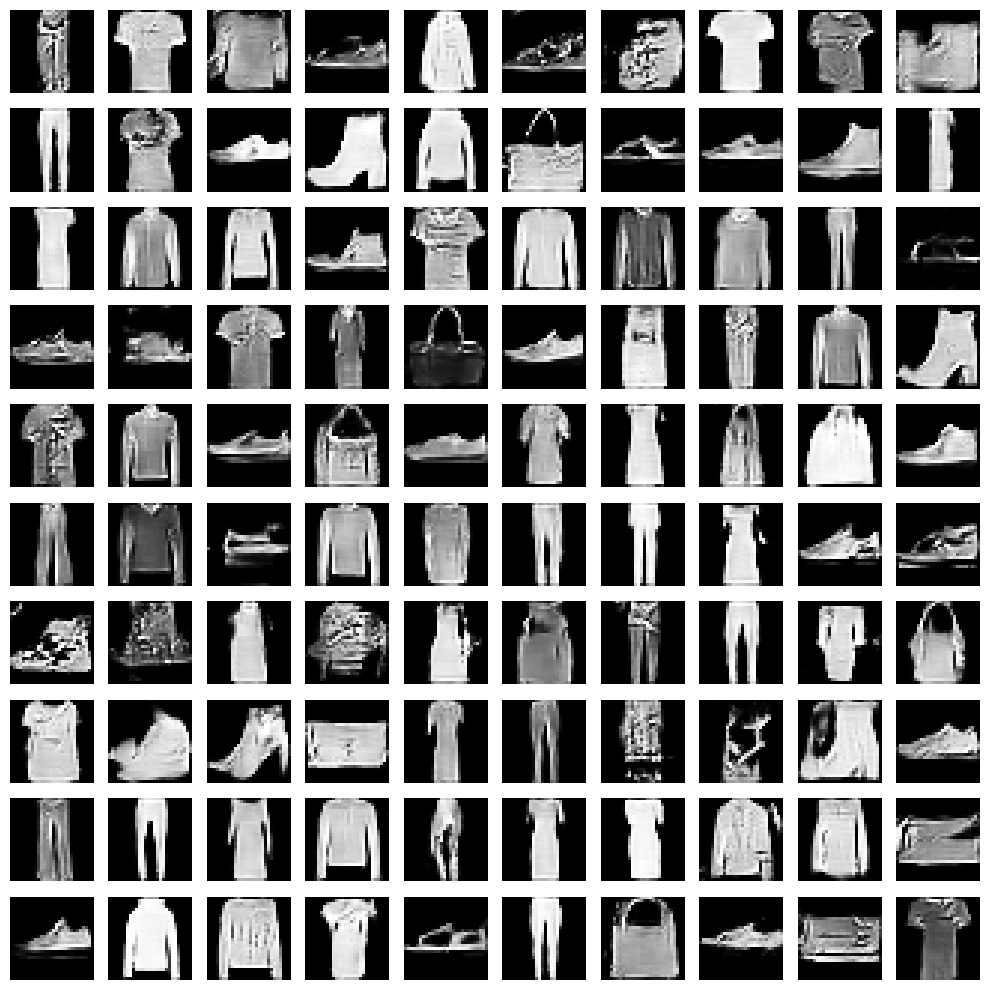

19       | 0.3993     | 2.0621     | 0.7394     | 0.2595


In [11]:
# Create a dictionary to store the logs
history = {
    'D_losses': [],
    'G_losses': [],
    'D_real_scores': [], # What D thinks of Real images (should be close to 1)
    'D_fake_scores': []  # What D thinks of Fake images (should be close to 0 initially)
}

def train_with_logging(epochs, save_interval=10):
    print(f"{'Epoch':<8} | {'D Loss':<10} | {'G Loss':<10} | {'D(x) Real':<10} | {'D(G(z)) Fake':<12}")
    print("-" * 65)

    for epoch in range(epochs):
        # accumulated scores for this epoch
        epoch_d_loss = 0
        epoch_g_loss = 0
        epoch_d_real_score = 0
        epoch_d_fake_score = 0

        for i, (imgs, _) in enumerate(dataloader):
            batch_size = imgs.shape[0]
            real_imgs = imgs.to(device)
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # --- LOGGING INPUTS (Just once for the very first batch) ---
            if epoch == 0 and i == 0:
                print("\n--- NETWORK INSPECTION (First Batch) ---")
                print(f"1. gen Input (Noise): {batch_size} vectors of size 100")
                print(f"2. gen Output (Fake Imgs): {batch_size} images of size {real_imgs.shape[1:]}")
                print(f"3. disc Input: Images of size {real_imgs.shape[1:]}")
                print("------------------------------------------\n")

            # ---------------------
            #  TRAIN disc
            # ---------------------
            optimizer_D.zero_grad()

            # Real Images
            real_pred = disc(real_imgs) # D output for Real
            d_loss_real = loss_func(real_pred, valid)

            # Fake Images
            noise = torch.randn(batch_size, 100, device=device) # G Input
            gen_imgs = gen(noise) # G Output
            fake_pred = disc(gen_imgs.detach()) # D output for Fake
            d_loss_fake = loss_func(fake_pred, fake)

            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  TRAIN gen
            # -----------------
            optimizer_G.zero_grad()
            validity = disc(gen_imgs)
            g_loss = loss_func(validity, valid)
            g_loss.backward()
            optimizer_G.step()

            # --- COLLECT STATS ---
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_d_real_score += real_pred.mean().item() # Avg score for real images
            epoch_d_fake_score += fake_pred.mean().item() # Avg score for fake images

        # --- END OF EPOCH LOGGING ---
        # Calculate averages for the whole epoch
        num_batches = len(dataloader)
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches
        avg_real_score = epoch_d_real_score / num_batches
        avg_fake_score = epoch_d_fake_score / num_batches

        # Store in history
        history['D_losses'].append(avg_d_loss)
        history['G_losses'].append(avg_g_loss)
        history['D_real_scores'].append(avg_real_score)
        history['D_fake_scores'].append(avg_fake_score)

        print(f"{epoch:<8} | {avg_d_loss:.4f}     | {avg_g_loss:.4f}     | {avg_real_score:.4f}     | {avg_fake_score:.4f}")

        if epoch % save_interval == 0:
            plot_generated_images(epoch, gen)

# Run it!
train_with_logging(epochs=20, save_interval=2)